#**Collecting Data**

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
while True:
  url = input("Enter Query: ")
  if url == "stop":
    break
  content = requests.get(url).content
  soup = BeautifulSoup(content, "html.parser")
  anchors = soup.find_all('a', class_='b-qt')
  with open("qoutes.txt", "w") as file:
    for anchor in anchors:
      file.write(anchor.text.replace('?','').replace("'",'').replace(".", "").replace('"', ''))
      file.write('\n')

In [ ]:
soup = BeautifulSoup(requests.get('https://www.brainyquote.com/').content, 'html.parser')

In [ ]:
urls = []
for url in soup.find_all("a", class_="bq_on_link_cl"):
  url = "https://www.brainyquote.com"+url.get("href")
  urls.append(url)

In [ ]:
len(urls)

24

In [ ]:
file = open('qoutes.txt', 'w')

In [ ]:
for link in urls:
  content = requests.get(link).content
  soup = BeautifulSoup(content, "html.parser")
  anchors = soup.find_all('a', class_='b-qt')
  print("Scrapping:", link)
  for anchor in anchors:
    file.write(anchor.text.replace('?','').replace("'",'').replace(".", "").replace('"', ''))
    file.write('\n')
file.close()

#**Preprocessing Data**

In [1]:
file = open('/content/qoutes.txt', 'r')
data = file.read()
file.close()

In [2]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
data = data.translate(translator)

In [3]:
data = data.replace('\n', ' ')

In [4]:
data

'I went to the woods because I wished to live deliberately  to front only the essential facts of life  and see if I could not learn what it had to teach  and not  when I came to die  discover that I had not lived If a man does not keep pace with his companions  perhaps it is because he hears a different drummer Let him step to the music which he hears  however measured or far away What lies behind us and what lies ahead of us are tiny matters compared to what lives within us Rather than love  than money  than fame  give me truth Its not what you look at that matters  its what you see Success usually comes to those who are too busy to be looking for it Many men go fishing all of their lives without knowing that it is not fish they are after If one advances confidently in the direction of his dreams  and endeavors to live the life which he has imagined  he will meet with a success unexpected in common hours An early morning walk is a blessing for the whole day This world is but a canvas 

In [5]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

In [6]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(data)

In [7]:
pickle.dump(tokenizer, open('tokenized_data.pkl', 'wb'))

In [8]:
sequence_data = tokenizer.texts_to_sequences([data])[0]
vocab_size = len(tokenizer.word_index) + 1

In [9]:
vocab_size

34

In [10]:
sequences = []

for i in range(1, len(sequence_data)):
  words = sequence_data[i - 1 : i + 1]
  sequences.append(words)


In [11]:
print("Total No of Sequences Are:", len(sequences))

Total No of Sequences Are: 815


In [12]:
import numpy as np

sequences = np.array(sequences)

In [13]:
X = sequences[: , 0]
Y = sequences[: , 1]

In [14]:
import tensorflow as tf

In [15]:
Y = tf.keras.utils.to_categorical(Y, num_classes=vocab_size)

#**Model**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [29]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.25))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(rate=0.25))

model.add(LSTM(512))
model.add(Dense(512, activation="relu",
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(256, activation="relu",
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(rate=0.3))

model.add(Dense(vocab_size, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 10)             340       
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 64)             19200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 256)            394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)              

In [31]:
print("Shape of Input Data:", X.shape)
print("Shape of Output Data:",Y.shape)

Shape of Input Data: (815,)
Shape of Output Data: (815, 34)


In [32]:
!rm -rf 'model.h5'

In [33]:
checkpoint = ModelCheckpoint("model.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [ ]:
history = model.fit(X, Y, epochs=500, batch_size=32, callbacks=[checkpoint, reduce, tensorboard_Visualization])

No handles with labels found to put in legend.


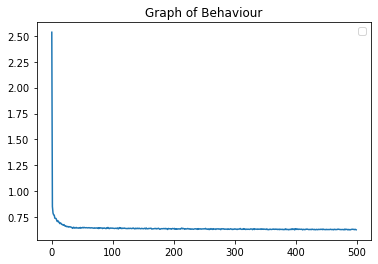

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Graph of Loss')
plt.legend()
plt.show()

No handles with labels found to put in legend.


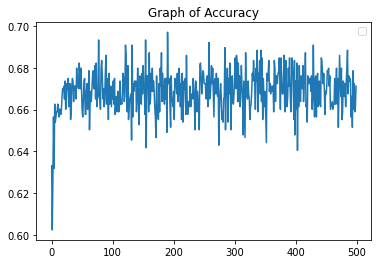

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Graph of Accuracy')
plt.legend()
plt.show()